#### Red Neuronal con PCA, Pesos por Clase y Hiperparámetros Optimizados (Optuna)
- **Optimización previa:** Selección de hiperparámetros óptimos excluyendo los partidos de validación.
- **Reducción de dimensionalidad:** PCA con varianza acumulada del 95%.
- **Balanceo de clases:** Pesos inversamente proporcionales a la frecuencia.
- **Validación secuencial:** Predicción partido a partido con actualización progresiva del entrenamiento.
- **Evaluación final:** Registro de métricas y matriz de confusión en MLflow.


In [9]:
import optuna
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import mlflow
import dagshub
import os

In [10]:
# Cargar datos
df = pd.read_csv("ath_bilbao.csv")
df = df.drop(columns=["season", "date", "team"])
df["rival_team"] = LabelEncoder().fit_transform(df["rival_team"])

X = df.drop(columns=["goals_team", "goals_rival", "result"])
y_raw = df["result"]

label_map = {-1: 0, 0: 1, 1: 2}
y = y_raw.map(label_map)

# Reservar 76 partidos finales para validación secuencial
n_val = 76
X_optuna = X.iloc[:-n_val].copy()
y_optuna = y.iloc[:-n_val].copy()

# Split para Optuna
X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(
    X_optuna, y_optuna, test_size=0.2, stratify=y_optuna, random_state=42
)


In [11]:
# Escalado
scaler_opt = StandardScaler()
X_train_scaled_opt = scaler_opt.fit_transform(X_train_opt)
X_val_scaled_opt = scaler_opt.transform(X_val_opt)

# PCA
pca_opt = PCA(n_components=0.95)
X_train_pca_opt = pca_opt.fit_transform(X_train_scaled_opt)
X_val_pca_opt = pca_opt.transform(X_val_scaled_opt)

# Pesos de clase
class_counts_opt = Counter(y_train_opt)
total_opt = sum(class_counts_opt.values())
class_weights_opt = {
    i: total_opt / (len(class_counts_opt) * class_counts_opt[i]) for i in class_counts_opt
}

In [12]:

# Función objetivo para Optuna
def objective(trial):
    model = Sequential()
    model.add(Input(shape=(X_train_pca_opt.shape[1],)))
    model.add(Dense(trial.suggest_int("units_1", 16, 64), activation='relu'))
    model.add(Dropout(trial.suggest_float("dropout_1", 0.1, 0.5)))
    model.add(Dense(trial.suggest_int("units_2", 8, 32), activation='relu'))
    model.add(Dropout(trial.suggest_float("dropout_2", 0.1, 0.5)))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    y_train_cat = to_categorical(y_train_opt, num_classes=3)
    y_val_cat = to_categorical(y_val_opt, num_classes=3)

    model.fit(
        X_train_pca_opt,
        y_train_cat,
        validation_data=(X_val_pca_opt, y_val_cat),
        epochs=trial.suggest_int("epochs", 10, 40),
        batch_size=trial.suggest_categorical("batch_size", [16, 32, 64]),
        verbose=0,
        class_weight=class_weights_opt
    )

    preds = model.predict(X_val_pca_opt)
    preds_labels = np.argmax(preds, axis=1)
    f1 = f1_score(y_val_opt, preds_labels, average="weighted", zero_division=0)
    return f1

In [13]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

[I 2025-03-27 21:40:38,293] A new study created in memory with name: no-name-044cfa0b-c682-444f-a055-0d23a7ee3411


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


[I 2025-03-27 21:40:48,384] Trial 0 finished with value: 0.40386234220436257 and parameters: {'units_1': 22, 'dropout_1': 0.20832188660225462, 'units_2': 28, 'dropout_2': 0.3513409436209848, 'epochs': 13, 'batch_size': 64}. Best is trial 0 with value: 0.40386234220436257.


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


[I 2025-03-27 21:40:59,721] Trial 1 finished with value: 0.4679068050233179 and parameters: {'units_1': 30, 'dropout_1': 0.49833802899013013, 'units_2': 25, 'dropout_2': 0.22226835607109796, 'epochs': 26, 'batch_size': 16}. Best is trial 1 with value: 0.4679068050233179.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


[I 2025-03-27 21:41:10,188] Trial 2 finished with value: 0.4814510901515294 and parameters: {'units_1': 60, 'dropout_1': 0.4490031457394179, 'units_2': 28, 'dropout_2': 0.4301523728259412, 'epochs': 21, 'batch_size': 16}. Best is trial 2 with value: 0.4814510901515294.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-03-27 21:41:19,780] Trial 3 finished with value: 0.39877041384744977 and parameters: {'units_1': 36, 'dropout_1': 0.4941945470540523, 'units_2': 32, 'dropout_2': 0.4372873845897599, 'epochs': 37, 'batch_size': 64}. Best is trial 2 with value: 0.4814510901515294.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-03-27 21:41:31,119] Trial 4 finished with value: 0.47769458128078823 and parameters: {'units_1': 55, 'dropout_1': 0.4747073866837356, 'units_2': 32, 'dropout_2': 0.4384362918867838, 'epochs': 38, 'batch_size': 64}. Best is trial 2 with value: 0.4814510901515294.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-03-27 21:41:44,359] Trial 5 finished with value: 0.4598796755468419 and parameters: {'units_1': 20, 'dropout_1': 0.35434748566437657, 'units_2': 12, 'dropout_2': 0.40729992709252427, 'epochs': 36, 'batch_size': 32}. Best is trial 2 with value: 0.4814510901515294.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-03-27 21:42:05,443] Trial 6 finished with value: 0.43712174524982406 and parameters: {'units_1': 49, 'dropout_1': 0.3383807149263759, 'units_2': 19, 'dropout_2': 0.4893183635701873, 'epochs': 37, 'batch_size': 64}. Best is trial 2 with value: 0.4814510901515294.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-03-27 21:42:17,355] Trial 7 finished with value: 0.37010986965268255 and parameters: {'units_1': 25, 'dropout_1': 0.41577986407274425, 'units_2': 29, 'dropout_2': 0.3850899375915633, 'epochs': 15, 'batch_size': 64}. Best is trial 2 with value: 0.4814510901515294.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


[I 2025-03-27 21:42:26,993] Trial 8 finished with value: 0.39088683746785524 and parameters: {'units_1': 26, 'dropout_1': 0.4519810529738616, 'units_2': 17, 'dropout_2': 0.2018959578407447, 'epochs': 12, 'batch_size': 16}. Best is trial 2 with value: 0.4814510901515294.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2025-03-27 21:42:38,948] Trial 9 finished with value: 0.4641785004507713 and parameters: {'units_1': 41, 'dropout_1': 0.17122821667064675, 'units_2': 9, 'dropout_2': 0.27709380273586104, 'epochs': 22, 'batch_size': 16}. Best is trial 2 with value: 0.4814510901515294.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-03-27 21:42:48,571] Trial 10 finished with value: 0.4259561128526646 and parameters: {'units_1': 64, 'dropout_1': 0.2625130788139061, 'units_2': 23, 'dropout_2': 0.11075376840118348, 'epochs': 26, 'batch_size': 32}. Best is trial 2 with value: 0.4814510901515294.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-03-27 21:42:59,384] Trial 11 finished with value: 0.45099391480730233 and parameters: {'units_1': 61, 'dropout_1': 0.4008384960082667, 'units_2': 32, 'dropout_2': 0.4952140153122348, 'epochs': 21, 'batch_size': 16}. Best is trial 2 with value: 0.4814510901515294.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


[I 2025-03-27 21:43:10,194] Trial 12 finished with value: 0.4408590278196354 and parameters: {'units_1': 53, 'dropout_1': 0.10522895428096196, 'units_2': 26, 'dropout_2': 0.3279509009317212, 'epochs': 30, 'batch_size': 64}. Best is trial 2 with value: 0.4814510901515294.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-03-27 21:43:24,393] Trial 13 finished with value: 0.4426899071447785 and parameters: {'units_1': 55, 'dropout_1': 0.42727301711645965, 'units_2': 23, 'dropout_2': 0.4410636087587494, 'epochs': 31, 'batch_size': 16}. Best is trial 2 with value: 0.4814510901515294.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


[I 2025-03-27 21:43:34,591] Trial 14 finished with value: 0.42401121972762323 and parameters: {'units_1': 45, 'dropout_1': 0.3666265043650584, 'units_2': 29, 'dropout_2': 0.29353284330694285, 'epochs': 18, 'batch_size': 32}. Best is trial 2 with value: 0.4814510901515294.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-03-27 21:43:44,312] Trial 15 finished with value: 0.45476368595363337 and parameters: {'units_1': 57, 'dropout_1': 0.3083438690055602, 'units_2': 32, 'dropout_2': 0.4491601148936298, 'epochs': 40, 'batch_size': 64}. Best is trial 2 with value: 0.4814510901515294.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-03-27 21:43:58,763] Trial 16 finished with value: 0.5114330740234603 and parameters: {'units_1': 49, 'dropout_1': 0.45179203265922024, 'units_2': 16, 'dropout_2': 0.37733614541065047, 'epochs': 31, 'batch_size': 16}. Best is trial 16 with value: 0.5114330740234603.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


[I 2025-03-27 21:44:12,506] Trial 17 finished with value: 0.45996618701927233 and parameters: {'units_1': 48, 'dropout_1': 0.3842625378330021, 'units_2': 15, 'dropout_2': 0.3674622971963612, 'epochs': 32, 'batch_size': 16}. Best is trial 16 with value: 0.5114330740234603.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2025-03-27 21:44:22,630] Trial 18 finished with value: 0.4505466778805719 and parameters: {'units_1': 38, 'dropout_1': 0.4447891318474457, 'units_2': 14, 'dropout_2': 0.2584186683108685, 'epochs': 23, 'batch_size': 16}. Best is trial 16 with value: 0.5114330740234603.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-03-27 21:44:34,328] Trial 19 finished with value: 0.4686686953966478 and parameters: {'units_1': 60, 'dropout_1': 0.26619444577034246, 'units_2': 20, 'dropout_2': 0.31755539063287164, 'epochs': 29, 'batch_size': 16}. Best is trial 16 with value: 0.5114330740234603.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-03-27 21:44:43,121] Trial 20 finished with value: 0.4604766894962428 and parameters: {'units_1': 50, 'dropout_1': 0.3256686098992743, 'units_2': 9, 'dropout_2': 0.3886825407930641, 'epochs': 18, 'batch_size': 16}. Best is trial 16 with value: 0.5114330740234603.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


[I 2025-03-27 21:44:56,924] Trial 21 finished with value: 0.48071350660851403 and parameters: {'units_1': 56, 'dropout_1': 0.46418275416282495, 'units_2': 22, 'dropout_2': 0.41901280492103204, 'epochs': 35, 'batch_size': 16}. Best is trial 16 with value: 0.5114330740234603.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-03-27 21:45:09,506] Trial 22 finished with value: 0.4916859240194444 and parameters: {'units_1': 64, 'dropout_1': 0.45967241282522464, 'units_2': 22, 'dropout_2': 0.4055260318196563, 'epochs': 34, 'batch_size': 16}. Best is trial 16 with value: 0.5114330740234603.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-03-27 21:45:23,647] Trial 23 finished with value: 0.48958442908596544 and parameters: {'units_1': 63, 'dropout_1': 0.41280375428088223, 'units_2': 17, 'dropout_2': 0.3549270784131834, 'epochs': 34, 'batch_size': 16}. Best is trial 16 with value: 0.5114330740234603.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


[I 2025-03-27 21:45:37,980] Trial 24 finished with value: 0.4293670262384609 and parameters: {'units_1': 62, 'dropout_1': 0.3977425328783999, 'units_2': 18, 'dropout_2': 0.344350018976315, 'epochs': 33, 'batch_size': 16}. Best is trial 16 with value: 0.5114330740234603.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-03-27 21:45:51,304] Trial 25 finished with value: 0.43498154938696354 and parameters: {'units_1': 43, 'dropout_1': 0.42412244764996276, 'units_2': 16, 'dropout_2': 0.3683572124200644, 'epochs': 34, 'batch_size': 16}. Best is trial 16 with value: 0.5114330740234603.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-03-27 21:46:03,133] Trial 26 finished with value: 0.4749845990846832 and parameters: {'units_1': 64, 'dropout_1': 0.37302749596411344, 'units_2': 13, 'dropout_2': 0.31511930041228786, 'epochs': 28, 'batch_size': 32}. Best is trial 16 with value: 0.5114330740234603.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


[I 2025-03-27 21:46:18,875] Trial 27 finished with value: 0.4487280104183232 and parameters: {'units_1': 33, 'dropout_1': 0.2763106711202882, 'units_2': 21, 'dropout_2': 0.47310198664613257, 'epochs': 39, 'batch_size': 16}. Best is trial 16 with value: 0.5114330740234603.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-03-27 21:46:34,327] Trial 28 finished with value: 0.44153501568560444 and parameters: {'units_1': 52, 'dropout_1': 0.47655302676213374, 'units_2': 12, 'dropout_2': 0.39597713159476094, 'epochs': 33, 'batch_size': 16}. Best is trial 16 with value: 0.5114330740234603.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-03-27 21:46:45,432] Trial 29 finished with value: 0.4272941366611639 and parameters: {'units_1': 17, 'dropout_1': 0.23196663794046332, 'units_2': 18, 'dropout_2': 0.3506146425008893, 'epochs': 28, 'batch_size': 16}. Best is trial 16 with value: 0.5114330740234603.


In [14]:
best_params = study.best_params
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'units_1': 49, 'dropout_1': 0.45179203265922024, 'units_2': 16, 'dropout_2': 0.37733614541065047, 'epochs': 31, 'batch_size': 16}


In [15]:
# Validación secuencial en los últimos 76 partidos
X_train_init = X.iloc[:-n_val].copy()
y_train_init = y.iloc[:-n_val].copy()
X_val_seq = X.iloc[-n_val:].copy()
y_val_seq = y_raw.iloc[-n_val:].copy()  # y_raw para mostrar etiquetas originales

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_init)
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)

y_pred_seq = []
y_real_seq = []

In [16]:

for i in range(n_val):
    model = Sequential()
    model.add(Input(shape=(X_train_pca.shape[1],)))
    model.add(Dense(best_params["units_1"], activation='relu'))
    model.add(Dropout(best_params["dropout_1"]))
    model.add(Dense(best_params["units_2"], activation='relu'))
    model.add(Dropout(best_params["dropout_2"]))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    class_counts = Counter(y_train_init)
    total = sum(class_counts.values())
    weights_seq = {
        lbl: total / (len(class_counts) * class_counts[lbl]) for lbl in class_counts
    }

    y_train_cat_seq = to_categorical(y_train_init, num_classes=3)

    model.fit(
        X_train_pca,
        y_train_cat_seq,
        epochs=best_params["epochs"],
        batch_size=best_params["batch_size"],
        verbose=0,
        class_weight=weights_seq
    )

    X_next = X_val_seq.iloc[i:i+1]
    y_next = y_val_seq.iloc[i]

    X_next_scaled = scaler.transform(X_next)
    X_next_pca = pca.transform(X_next_scaled)

    pred_prob = model.predict(X_next_pca)
    pred_label = np.argmax(pred_prob, axis=1)[0]

    y_pred_seq.append(pred_label)
    y_real_seq.append(y_next)

    X_train_init = pd.concat([X_train_init, X_next])
    y_train_init = pd.concat([y_train_init, pd.Series([label_map[y_next]])])

    X_train_scaled = scaler.fit_transform(X_train_init)
    X_train_pca = pca.fit_transform(X_train_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [17]:
mapped_real = [label_map[y] for y in y_real_seq]
acc = accuracy_score(mapped_real, y_pred_seq)
prec = precision_score(mapped_real, y_pred_seq, average="weighted", zero_division=0)
rec = recall_score(mapped_real, y_pred_seq, average="weighted", zero_division=0)
f1 = f1_score(mapped_real, y_pred_seq, average="weighted", zero_division=0)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1:", f1)

rep = classification_report(
    mapped_real,
    y_pred_seq,
    labels=[0,1,2],
    target_names=["Derrota (-1)", "Empate (0)", "Victoria (1)"],
    zero_division=0
)
print("\nReporte de Clasificación:\n", rep)

Accuracy: 0.4342105263157895
Precision: 0.43186795818374774
Recall: 0.4342105263157895
F1: 0.43040528149642404

Reporte de Clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.44      0.35      0.39        23
  Empate (0)       0.24      0.25      0.24        20
Victoria (1)       0.54      0.61      0.57        33

    accuracy                           0.43        76
   macro avg       0.41      0.40      0.40        76
weighted avg       0.43      0.43      0.43        76



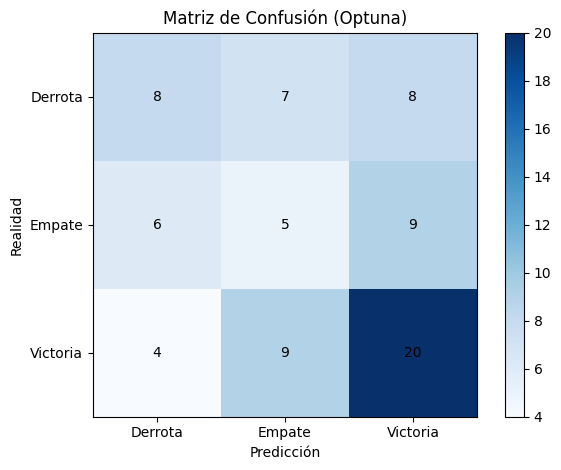

In [18]:
cm = confusion_matrix(mapped_real, y_pred_seq, labels=[0,1,2])
plt.imshow(cm, cmap="Blues", interpolation="nearest")
plt.colorbar()
plt.xticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
plt.yticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.title("Matriz de Confusión (Optuna)")
for row in range(cm.shape[0]):
    for col in range(cm.shape[1]):
        plt.text(col, row, cm[row, col], ha="center", va="center", color="black")
plt.tight_layout()
plt.savefig("conf_matrix_optuna.png")
plt.show()
plt.close()

In [19]:
USERNAME = "anaigs"
TOKEN = "6906b8ec6ea34a63bacb40b89eed8c6e9b9ff49d"
REPO_NAME = "tfg_inso_github"

mlflow.set_tracking_uri(f"https://dagshub.com/{USERNAME}/{REPO_NAME}.mlflow")
dagshub.init(repo_owner=USERNAME, repo_name=REPO_NAME, mlflow=True)
print(mlflow.get_tracking_uri())

with mlflow.start_run(run_name="ath_bilbao_nn_optuna"):
    mlflow.log_param("model_type", "Neural Network")
    mlflow.log_param("approach", "NN + Sequential + PCA")
    mlflow.log_param("test_size", n_val)

    for p, val in best_params.items():
        mlflow.log_param(p, val)

    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)

    mlflow.log_artifact("conf_matrix_optuna.png")
    os.remove("conf_matrix_optuna.png")

    print("Resultados registrados en MLflow.")

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=c41300e3-6141-4a74-a0f3-6081defe7845&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=2322b1ac82465ade903ca1be24d3aad536437248a70684fe5e39e1760d799d0a




Accessing as anaigs

Initialized MLflow to track repo "anaigs/tfg_inso_github"

Repository anaigs/tfg_inso_github initialized!

https://dagshub.com/anaigs/tfg_inso_github.mlflow
Resultados registrados en MLflow.
🏃 View run ath_bilbao_nn_optuna at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/66cf259b9ad644059e2b4f1929573280
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


### Conclusión: Red Neuronal con Optuna, PCA y Pesos por Clase

- **Precisión global:** 43.42%, ligeramente inferior a modelos anteriores.
- **Predicción de victorias:** Se mantiene como la clase con mejor rendimiento (F1: 0.57).
- **Predicción de empates y derrotas:** Sigue habiendo confusión entre clases, especialmente entre empates y victorias.
- **Impacto de Optuna:** No ha mejorado el rendimiento general respecto a la red base + PCA + pesos.


#### Red Neuronal sin PCA con EarlyStopping (F1 optimizado)
- No se aplica reducción de dimensionalidad (sin PCA).
- Se usa EarlyStopping para evitar sobreentrenamiento.
- Pesos de clase calculados automáticamente según distribución real.
- Hiperparámetros fijados según el mejor resultado obtenido con Optuna.
- Validación secuencial con 76 partidos (una predicción por partido).


In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from collections import Counter
import matplotlib.pyplot as plt
import mlflow
import dagshub
import os

In [35]:
# Cargar y preparar datos
df = pd.read_csv("ath_bilbao.csv")
df = df.drop(columns=["season", "date", "team"])
df["rival_team"] = LabelEncoder().fit_transform(df["rival_team"])

X = df.drop(columns=["goals_team", "goals_rival", "result"])
y_raw = df["result"]
label_map = {-1: 0, 0: 1, 1: 2}
y = y_raw.map(label_map)

# Separar datos para validación secuencial
n_val = 76
X_train_init = X.iloc[:-n_val].copy()
y_train_init = y.iloc[:-n_val].copy()
X_val_seq = X.iloc[-n_val:].copy()
y_val_seq = y_raw.iloc[-n_val:].copy()

# Escalado inicial
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_init)

In [36]:

# Hiperparámetros de Optuna
params = {
    'units_1': 40,
    'dropout_1': 0.275,
    'units_2': 23,
    'dropout_2': 0.375,
    'epochs': 30,
    'batch_size': 16
}

# Inicializar listas
y_pred_seq = []
y_real_seq = []

In [37]:

# Validación secuencial
for i in range(n_val):
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1],)))
    model.add(Dense(params['units_1'], activation='relu'))
    model.add(Dropout(params['dropout_1']))
    model.add(Dense(params['units_2'], activation='relu'))
    model.add(Dropout(params['dropout_2']))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    y_train_cat = to_categorical(y_train_init, num_classes=3)

    class_counts = Counter(y_train_init)
    total = sum(class_counts.values())
    weights = {i: total / (len(class_counts) * class_counts[i]) for i in class_counts}

    es = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

    model.fit(
        X_train_scaled,
        y_train_cat,
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        verbose=0,
        class_weight=weights,
        callbacks=[es]
    )

    X_next = X_val_seq.iloc[i:i+1]
    y_next = y_val_seq.iloc[i]

    X_next_scaled = scaler.transform(X_next)
    pred_prob = model.predict(X_next_scaled)
    pred_label = np.argmax(pred_prob, axis=1)[0]

    y_pred_seq.append(pred_label)
    y_real_seq.append(y_next)

    X_train_init = pd.concat([X_train_init, X_next])
    y_train_init = pd.concat([y_train_init, pd.Series([label_map[y_next]])])
    X_train_scaled = scaler.fit_transform(X_train_init)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━

In [24]:

# Evaluar modelo
mapped_real = [label_map[y] for y in y_real_seq]

acc = accuracy_score(mapped_real, y_pred_seq)
prec = precision_score(mapped_real, y_pred_seq, average="weighted", zero_division=0)
rec = recall_score(mapped_real, y_pred_seq, average="weighted", zero_division=0)
f1 = f1_score(mapped_real, y_pred_seq, average="weighted", zero_division=0)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1:", f1)

rep = classification_report(
    mapped_real,
    y_pred_seq,
    labels=[0,1,2],
    target_names=["Derrota (-1)", "Empate (0)", "Victoria (1)"],
    zero_division=0
)
print("\nReporte de Clasificación:\n", rep)

Accuracy: 0.5
Precision: 0.5239606624813667
Recall: 0.5
F1: 0.5055549573606685

Reporte de Clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.65      0.48      0.55        23
  Empate (0)       0.37      0.50      0.43        20
Victoria (1)       0.53      0.52      0.52        33

    accuracy                           0.50        76
   macro avg       0.52      0.50      0.50        76
weighted avg       0.52      0.50      0.51        76



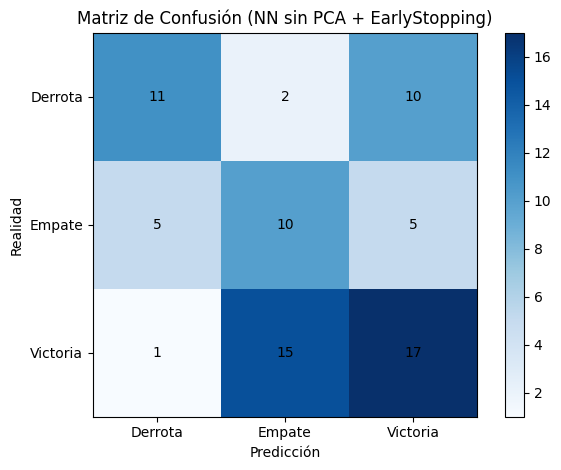

In [27]:

cm = confusion_matrix(mapped_real, y_pred_seq, labels=[0,1,2])
plt.imshow(cm, cmap="Blues", interpolation="nearest")
plt.colorbar()
plt.xticks([0,1,2], ["Derrota", "Empate", "Victoria"])
plt.yticks([0,1,2], ["Derrota", "Empate", "Victoria"])
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.title("Matriz de Confusión (NN sin PCA + EarlyStopping)")
for row in range(cm.shape[0]):
    for col in range(cm.shape[1]):
        plt.text(col, row, cm[row, col], ha="center", va="center", color="black")
plt.tight_layout()
plt.show()
plt.savefig("conf_matrix_nn_no_pca.png")
plt.close()

In [26]:

# Registrar en MLflow
USERNAME = "anaigs"
TOKEN = "6906b8ec6ea34a63bacb40b89eed8c6e9b9ff49d"
REPO_NAME = "tfg_inso_github"

mlflow.set_tracking_uri(f"https://dagshub.com/{USERNAME}/{REPO_NAME}.mlflow")
dagshub.init(repo_owner=USERNAME, repo_name=REPO_NAME, mlflow=True)
print(mlflow.get_tracking_uri())

with mlflow.start_run(run_name="ath_bilbao_nn_no_pca_earlystopping"):
    mlflow.log_param("model_type", "Neural Network")
    mlflow.log_param("approach", "NN + Sequential + EarlyStopping")
    mlflow.log_param("test_size", n_val)

    for p, val in params.items():
        mlflow.log_param(p, val)

    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)

    mlflow.log_artifact("conf_matrix_nn_no_pca.png")
    os.remove("conf_matrix_nn_no_pca.png")

    print("Resultados registrados en MLflow.")

Initialized MLflow to track repo "anaigs/tfg_inso_github"

Repository anaigs/tfg_inso_github initialized!

https://dagshub.com/anaigs/tfg_inso_github.mlflow
Resultados registrados en MLflow.
🏃 View run ath_bilbao_nn_no_pca_earlystopping at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/70281f0f4a3640e39479805994a2f2f7
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


### Conclusión: Red Neuronal sin PCA con EarlyStopping

- **Precisión global:** 50.00%, mejora respecto a versiones anteriores con PCA.
- **Predicción de empates:** Subida significativa en recall (0.50) y f1-score (0.43), lo que indica que el modelo empieza a detectar mejor esta clase.
- **Predicción de derrotas:** Buen precision (0.65), aunque sigue habiendo confusión con victorias.
- **Predicción de victorias:** Se mantiene estable (F1: 0.52).
- **Impacto general:** Quitar PCA y añadir EarlyStopping mejora el equilibrio entre clases y aumenta el F1 global a 0.505.


#### Red Neuronal optimizada con Optuna (sin PCA) por equipo
- Se entrena un modelo por equipo, usando su propio CSV.
- Optuna busca la mejor combinación de:
  - Capas ocultas, dropout, batch size, epochs.
- No se aplica PCA.
- Se entrena con pesos de clase automáticos.
- Se valida de forma secuencial, partido a partido.
- Se registra el resultado en MLflow junto con la matriz de confusión.


In [45]:
import optuna
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import mlflow
import dagshub

In [46]:

# MLflow setup
USERNAME = "anaigs"
TOKEN = "6906b8ec6ea34a63bacb40b89eed8c6e9b9ff49d"
REPO_NAME = "tfg_inso_github"

mlflow.set_tracking_uri(f"https://dagshub.com/{USERNAME}/{REPO_NAME}.mlflow")
dagshub.init(repo_owner=USERNAME, repo_name=REPO_NAME, mlflow=True)

equipos = ["barcelona", "real_madrid", "valencia"]

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=88b65943-3950-411d-a3a5-453664a8489f&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=6f4dac641df78ef9a838624720c02e4a15fc9bcfe8f1d8da0a95126cc6c8b3a3




Accessing as anaigs

Initialized MLflow to track repo "anaigs/tfg_inso_github"

Repository anaigs/tfg_inso_github initialized!

In [48]:

for equipo in equipos:
    print(f"\n===== Procesando equipo: {equipo} =====\n")
    df = pd.read_csv(f"{equipo}.csv")
    df = df.drop(columns=["season", "date", "team"])
    df["rival_team"] = LabelEncoder().fit_transform(df["rival_team"])

    X = df.drop(columns=["goals_team", "goals_rival", "result"])
    y_raw = df["result"]
    label_map = {-1: 0, 0: 1, 1: 2}
    y = y_raw.map(label_map)

    n_val = 76
    X_optuna = X.iloc[:-n_val]
    y_optuna = y.iloc[:-n_val]

    X_train, X_val, y_train, y_val = train_test_split(
        X_optuna, y_optuna, test_size=0.2, stratify=y_optuna, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    class_counts = Counter(y_train)
    total = sum(class_counts.values())
    class_weights = {i: total / (len(class_counts) * class_counts[i]) for i in class_counts}

    def objective(trial):
        model = Sequential()
        model.add(Input(shape=(X_train_scaled.shape[1],)))
        model.add(Dense(trial.suggest_int("units_1", 24, 64), activation="relu"))
        model.add(Dropout(trial.suggest_float("dropout_1", 0.2, 0.5)))
        model.add(Dense(trial.suggest_int("units_2", 16, 48), activation="relu"))
        model.add(Dropout(trial.suggest_float("dropout_2", 0.2, 0.5)))
        model.add(Dense(3, activation="softmax"))
        model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

        y_train_cat = to_categorical(y_train, num_classes=3)
        y_val_cat = to_categorical(y_val, num_classes=3)

        es = EarlyStopping(monitor="loss", patience=3, restore_best_weights=True, verbose=0)

        model.fit(
            X_train_scaled, y_train_cat,
            epochs=trial.suggest_int("epochs", 20, 40),
            batch_size=trial.suggest_categorical("batch_size", [16, 32]),
            class_weight=class_weights,
            verbose=0,
            callbacks=[es],
            validation_data=(X_val_scaled, y_val_cat)
        )

        preds = model.predict(X_val_scaled)
        preds_labels = np.argmax(preds, axis=1)
        return f1_score(y_val, preds_labels, average="weighted", zero_division=0)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=30)
    best_params = study.best_params

    # Validación secuencial
    X_train_init = X.iloc[:-n_val].copy()
    y_train_init = y.iloc[:-n_val].copy()
    X_val_seq = X.iloc[-n_val:].copy()
    y_val_seq = y_raw.iloc[-n_val:].copy()
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_init)

    y_pred_seq = []
    y_real_seq = []

    for i in range(n_val):
        model = Sequential()
        model.add(Input(shape=(X_train_scaled.shape[1],)))
        model.add(Dense(best_params["units_1"], activation="relu"))
        model.add(Dropout(best_params["dropout_1"]))
        model.add(Dense(best_params["units_2"], activation="relu"))
        model.add(Dropout(best_params["dropout_2"]))
        model.add(Dense(3, activation="softmax"))
        model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

        y_train_cat = to_categorical(y_train_init, num_classes=3)
        counts = Counter(y_train_init)
        total = sum(counts.values())
        weights_seq = {i: total / (len(counts) * counts[i]) for i in counts}

        es = EarlyStopping(monitor="loss", patience=3, restore_best_weights=True, verbose=0)

        model.fit(
            X_train_scaled, y_train_cat,
            epochs=best_params["epochs"],
            batch_size=best_params["batch_size"],
            verbose=0,
            class_weight=weights_seq,
            callbacks=[es]
        )

        X_next = X_val_seq.iloc[i:i+1]
        y_next = y_val_seq.iloc[i]
        X_next_scaled = scaler.transform(X_next)

        pred_prob = model.predict(X_next_scaled)
        pred_label = np.argmax(pred_prob, axis=1)[0]

        y_pred_seq.append(pred_label)
        y_real_seq.append(y_next)

        X_train_init = pd.concat([X_train_init, X_next])
        y_train_init = pd.concat([y_train_init, pd.Series([label_map[y_next]])])
        X_train_scaled = scaler.fit_transform(X_train_init)

    mapped_real = [label_map[y] for y in y_real_seq]
    acc = accuracy_score(mapped_real, y_pred_seq)
    prec = precision_score(mapped_real, y_pred_seq, average="weighted", zero_division=0)
    rec = recall_score(mapped_real, y_pred_seq, average="weighted", zero_division=0)
    f1 = f1_score(mapped_real, y_pred_seq, average="weighted", zero_division=0)

    print(f"{equipo.upper()} - F1: {f1:.4f} | Accuracy: {acc:.4f}")

    cm = confusion_matrix(mapped_real, y_pred_seq, labels=[0, 1, 2])
    plt.imshow(cm, cmap="Blues", interpolation="nearest")
    plt.colorbar()
    plt.xticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.yticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.xlabel("Predicción")
    plt.ylabel("Realidad")
    plt.title(f"Matriz de Confusión (Optuna - {equipo.title()})")
    for i in range(3):
        for j in range(3):
            plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
    plt.tight_layout()
    image_name = f"conf_matrix_{equipo}_optuna.png"
    plt.savefig(image_name)
    plt.close()

    with mlflow.start_run(run_name=f"{equipo}_nn_optuna"):
        mlflow.log_param("model_type", "Neural Network")
        mlflow.log_param("approach", "NN + Sequential + Optuna")
        mlflow.log_param("team", equipo)
        mlflow.log_param("test_size", n_val)

        for k, v in best_params.items():
            mlflow.log_param(k, v)

        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("f1_score", f1)

        mlflow.log_artifact(image_name)
        os.remove(image_name)

        print(f"→ Resultados para {equipo} registrados en MLflow.")

[I 2025-03-27 23:39:29,959] A new study created in memory with name: no-name-e3246da8-1e74-4948-8aaf-113cf38196f3



===== Procesando equipo: barcelona =====

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:39:34,744] Trial 0 finished with value: 0.5213470187982931 and parameters: {'units_1': 58, 'dropout_1': 0.27853387683510894, 'units_2': 47, 'dropout_2': 0.41814119292887975, 'epochs': 34, 'batch_size': 16}. Best is trial 0 with value: 0.5213470187982931.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:39:38,998] Trial 1 finished with value: 0.45518252603903325 and parameters: {'units_1': 56, 'dropout_1': 0.3075119401211095, 'units_2': 33, 'dropout_2': 0.4883417668955568, 'epochs': 24, 'batch_size': 16}. Best is trial 0 with value: 0.5213470187982931.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-27 23:39:42,547] Trial 2 finished with value: 0.47811003201636243 and parameters: {'units_1': 45, 'dropout_1': 0.25713479194745015, 'units_2': 35, 'dropout_2': 0.3418160640486797, 'epochs': 34, 'batch_size': 32}. Best is trial 0 with value: 0.5213470187982931.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-27 23:39:46,339] Trial 3 finished with value: 0.47733185567384906 and parameters: {'units_1': 32, 'dropout_1': 0.364655885285722, 'units_2': 42, 'dropout_2': 0.37868780160487125, 'epochs': 24, 'batch_size': 16}. Best is trial 0 with value: 0.5213470187982931.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:39:51,193] Trial 4 finished with value: 0.5175112098726241 and parameters: {'units_1': 42, 'dropout_1': 0.2851111412487463, 'units_2': 28, 'dropout_2': 0.3609625591465183, 'epochs': 36, 'batch_size': 16}. Best is trial 0 with value: 0.5213470187982931.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:39:56,205] Trial 5 finished with value: 0.5372883264312417 and parameters: {'units_1': 64, 'dropout_1': 0.21969842239638407, 'units_2': 17, 'dropout_2': 0.37607138171694887, 'epochs': 33, 'batch_size': 32}. Best is trial 5 with value: 0.5372883264312417.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:39:59,307] Trial 6 finished with value: 0.45830549702793916 and parameters: {'units_1': 37, 'dropout_1': 0.3301984349888638, 'units_2': 29, 'dropout_2': 0.39285416648478544, 'epochs': 38, 'batch_size': 32}. Best is trial 5 with value: 0.5372883264312417.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-27 23:40:03,194] Trial 7 finished with value: 0.5053823662318426 and parameters: {'units_1': 36, 'dropout_1': 0.33791932570324, 'units_2': 30, 'dropout_2': 0.32324373592780997, 'epochs': 35, 'batch_size': 32}. Best is trial 5 with value: 0.5372883264312417.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-27 23:40:06,223] Trial 8 finished with value: 0.4882559363468713 and parameters: {'units_1': 31, 'dropout_1': 0.4290038228441799, 'units_2': 20, 'dropout_2': 0.36190296940451405, 'epochs': 28, 'batch_size': 32}. Best is trial 5 with value: 0.5372883264312417.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:40:09,347] Trial 9 finished with value: 0.5033236047221592 and parameters: {'units_1': 63, 'dropout_1': 0.32071412686686324, 'units_2': 38, 'dropout_2': 0.20123724843310403, 'epochs': 31, 'batch_size': 16}. Best is trial 5 with value: 0.5372883264312417.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:40:13,603] Trial 10 finished with value: 0.5170608009531015 and parameters: {'units_1': 51, 'dropout_1': 0.21871617454070416, 'units_2': 16, 'dropout_2': 0.2701889959831365, 'epochs': 20, 'batch_size': 32}. Best is trial 5 with value: 0.5372883264312417.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-27 23:40:18,029] Trial 11 finished with value: 0.5225869333964027 and parameters: {'units_1': 64, 'dropout_1': 0.2186875988395321, 'units_2': 47, 'dropout_2': 0.4468820191223402, 'epochs': 40, 'batch_size': 16}. Best is trial 5 with value: 0.5372883264312417.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:40:21,702] Trial 12 finished with value: 0.4820197044334975 and parameters: {'units_1': 63, 'dropout_1': 0.21599474000447974, 'units_2': 24, 'dropout_2': 0.4530756363593099, 'epochs': 40, 'batch_size': 16}. Best is trial 5 with value: 0.5372883264312417.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-27 23:40:27,545] Trial 13 finished with value: 0.4632122021475036 and parameters: {'units_1': 52, 'dropout_1': 0.20924721072031846, 'units_2': 47, 'dropout_2': 0.44176308029707545, 'epochs': 31, 'batch_size': 32}. Best is trial 5 with value: 0.5372883264312417.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:40:31,792] Trial 14 finished with value: 0.5500770493873942 and parameters: {'units_1': 64, 'dropout_1': 0.3875125098361293, 'units_2': 23, 'dropout_2': 0.49294076593219105, 'epochs': 39, 'batch_size': 32}. Best is trial 14 with value: 0.5500770493873942.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-27 23:40:36,627] Trial 15 finished with value: 0.4144256638803886 and parameters: {'units_1': 57, 'dropout_1': 0.39658966351831887, 'units_2': 16, 'dropout_2': 0.496468257161799, 'epochs': 28, 'batch_size': 32}. Best is trial 14 with value: 0.5500770493873942.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-27 23:40:40,714] Trial 16 finished with value: 0.48814560968950443 and parameters: {'units_1': 49, 'dropout_1': 0.4710260246178337, 'units_2': 23, 'dropout_2': 0.2945919774263372, 'epochs': 37, 'batch_size': 32}. Best is trial 14 with value: 0.5500770493873942.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:40:45,871] Trial 17 finished with value: 0.5246757247599293 and parameters: {'units_1': 59, 'dropout_1': 0.3748824196683428, 'units_2': 21, 'dropout_2': 0.23579944200690459, 'epochs': 32, 'batch_size': 32}. Best is trial 14 with value: 0.5500770493873942.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-27 23:40:49,517] Trial 18 finished with value: 0.48343391790720974 and parameters: {'units_1': 45, 'dropout_1': 0.42628174643677047, 'units_2': 25, 'dropout_2': 0.4051170983359689, 'epochs': 38, 'batch_size': 32}. Best is trial 14 with value: 0.5500770493873942.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-27 23:40:52,498] Trial 19 finished with value: 0.531513904740248 and parameters: {'units_1': 24, 'dropout_1': 0.47249709425313313, 'units_2': 20, 'dropout_2': 0.3109612469870324, 'epochs': 28, 'batch_size': 32}. Best is trial 14 with value: 0.5500770493873942.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-27 23:40:56,362] Trial 20 finished with value: 0.5070930425637903 and parameters: {'units_1': 54, 'dropout_1': 0.40333463384460644, 'units_2': 17, 'dropout_2': 0.4716240036926694, 'epochs': 33, 'batch_size': 32}. Best is trial 14 with value: 0.5500770493873942.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:40:59,264] Trial 21 finished with value: 0.5252441374991034 and parameters: {'units_1': 25, 'dropout_1': 0.49834669179428365, 'units_2': 20, 'dropout_2': 0.307407207547011, 'epochs': 28, 'batch_size': 32}. Best is trial 14 with value: 0.5500770493873942.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-27 23:41:02,327] Trial 22 finished with value: 0.4738220805563605 and parameters: {'units_1': 24, 'dropout_1': 0.4531821679111927, 'units_2': 26, 'dropout_2': 0.276603294279276, 'epochs': 25, 'batch_size': 32}. Best is trial 14 with value: 0.5500770493873942.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-27 23:41:04,868] Trial 23 finished with value: 0.49027066622382176 and parameters: {'units_1': 61, 'dropout_1': 0.4900725253902648, 'units_2': 19, 'dropout_2': 0.33408092036851905, 'epochs': 29, 'batch_size': 32}. Best is trial 14 with value: 0.5500770493873942.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-27 23:41:08,447] Trial 24 finished with value: 0.4412679347528014 and parameters: {'units_1': 40, 'dropout_1': 0.4460260643809971, 'units_2': 22, 'dropout_2': 0.2443209249170554, 'epochs': 26, 'batch_size': 32}. Best is trial 14 with value: 0.5500770493873942.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-27 23:41:11,888] Trial 25 finished with value: 0.4497466728873674 and parameters: {'units_1': 29, 'dropout_1': 0.3917773894865044, 'units_2': 18, 'dropout_2': 0.41166034565092274, 'epochs': 22, 'batch_size': 32}. Best is trial 14 with value: 0.5500770493873942.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:41:14,970] Trial 26 finished with value: 0.5948026870737929 and parameters: {'units_1': 47, 'dropout_1': 0.24913581712514699, 'units_2': 27, 'dropout_2': 0.300571092066855, 'epochs': 30, 'batch_size': 32}. Best is trial 26 with value: 0.5948026870737929.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-27 23:41:19,549] Trial 27 finished with value: 0.5488192267502612 and parameters: {'units_1': 60, 'dropout_1': 0.24880843454543078, 'units_2': 28, 'dropout_2': 0.27502890191897317, 'epochs': 31, 'batch_size': 32}. Best is trial 26 with value: 0.5948026870737929.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:41:23,135] Trial 28 finished with value: 0.46916356818853844 and parameters: {'units_1': 48, 'dropout_1': 0.2462549015594424, 'units_2': 27, 'dropout_2': 0.24738141325329382, 'epochs': 30, 'batch_size': 32}. Best is trial 26 with value: 0.5948026870737929.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-27 23:41:27,703] Trial 29 finished with value: 0.4750267413236884 and parameters: {'units_1': 59, 'dropout_1': 0.28621693630996825, 'units_2': 31, 'dropout_2': 0.2767257098006559, 'epochs': 26, 'batch_size': 32}. Best is trial 26 with value: 0.5948026870737929.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━

[I 2025-03-27 23:45:20,790] A new study created in memory with name: no-name-1d245159-5573-4a9d-82c8-fcfe331f198e



===== Procesando equipo: real_madrid =====

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:45:25,544] Trial 0 finished with value: 0.5737300782381919 and parameters: {'units_1': 61, 'dropout_1': 0.2758756450674722, 'units_2': 42, 'dropout_2': 0.3376566092306396, 'epochs': 30, 'batch_size': 16}. Best is trial 0 with value: 0.5737300782381919.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-27 23:45:32,137] Trial 1 finished with value: 0.5269589370243406 and parameters: {'units_1': 40, 'dropout_1': 0.390148480750982, 'units_2': 35, 'dropout_2': 0.33811972207304636, 'epochs': 33, 'batch_size': 16}. Best is trial 0 with value: 0.5737300782381919.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-27 23:45:36,779] Trial 2 finished with value: 0.5072753255202832 and parameters: {'units_1': 29, 'dropout_1': 0.21021191947422407, 'units_2': 42, 'dropout_2': 0.30370891425942204, 'epochs': 34, 'batch_size': 32}. Best is trial 0 with value: 0.5737300782381919.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-27 23:45:39,935] Trial 3 finished with value: 0.5608919616734904 and parameters: {'units_1': 51, 'dropout_1': 0.3132590488294314, 'units_2': 20, 'dropout_2': 0.3578683236825128, 'epochs': 26, 'batch_size': 32}. Best is trial 0 with value: 0.5737300782381919.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:45:44,499] Trial 4 finished with value: 0.5057306117056414 and parameters: {'units_1': 43, 'dropout_1': 0.36178860390958223, 'units_2': 33, 'dropout_2': 0.20597844293614992, 'epochs': 34, 'batch_size': 16}. Best is trial 0 with value: 0.5737300782381919.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:45:48,845] Trial 5 finished with value: 0.5277298371473922 and parameters: {'units_1': 58, 'dropout_1': 0.4212640395053081, 'units_2': 35, 'dropout_2': 0.2047504911590914, 'epochs': 38, 'batch_size': 32}. Best is trial 0 with value: 0.5737300782381919.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:45:53,769] Trial 6 finished with value: 0.5251519032505739 and parameters: {'units_1': 57, 'dropout_1': 0.32954424557034956, 'units_2': 18, 'dropout_2': 0.3713983872998702, 'epochs': 34, 'batch_size': 16}. Best is trial 0 with value: 0.5737300782381919.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:46:00,068] Trial 7 finished with value: 0.5241896964197327 and parameters: {'units_1': 37, 'dropout_1': 0.41868042541355666, 'units_2': 38, 'dropout_2': 0.352597257967336, 'epochs': 27, 'batch_size': 16}. Best is trial 0 with value: 0.5737300782381919.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-27 23:46:03,522] Trial 8 finished with value: 0.5361761808171545 and parameters: {'units_1': 45, 'dropout_1': 0.25301209973495087, 'units_2': 44, 'dropout_2': 0.29857571910047365, 'epochs': 24, 'batch_size': 16}. Best is trial 0 with value: 0.5737300782381919.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-27 23:46:08,479] Trial 9 finished with value: 0.48336535544544446 and parameters: {'units_1': 51, 'dropout_1': 0.2108593453703586, 'units_2': 30, 'dropout_2': 0.32484972890110797, 'epochs': 39, 'batch_size': 16}. Best is trial 0 with value: 0.5737300782381919.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-27 23:46:12,342] Trial 10 finished with value: 0.5639749488907936 and parameters: {'units_1': 63, 'dropout_1': 0.48724193754050693, 'units_2': 48, 'dropout_2': 0.4798269648804815, 'epochs': 20, 'batch_size': 32}. Best is trial 0 with value: 0.5737300782381919.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:46:15,657] Trial 11 finished with value: 0.5324544100646746 and parameters: {'units_1': 62, 'dropout_1': 0.49343486214917454, 'units_2': 47, 'dropout_2': 0.4964568097839269, 'epochs': 21, 'batch_size': 32}. Best is trial 0 with value: 0.5737300782381919.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-27 23:46:20,392] Trial 12 finished with value: 0.5414281985965763 and parameters: {'units_1': 64, 'dropout_1': 0.26875885824395207, 'units_2': 48, 'dropout_2': 0.4695102496977832, 'epochs': 20, 'batch_size': 32}. Best is trial 0 with value: 0.5737300782381919.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:46:24,592] Trial 13 finished with value: 0.5643551850448403 and parameters: {'units_1': 54, 'dropout_1': 0.49989671945950864, 'units_2': 41, 'dropout_2': 0.41996131594631486, 'epochs': 30, 'batch_size': 32}. Best is trial 0 with value: 0.5737300782381919.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-27 23:46:29,715] Trial 14 finished with value: 0.45883035022078406 and parameters: {'units_1': 53, 'dropout_1': 0.2825019110486717, 'units_2': 28, 'dropout_2': 0.41510035151376423, 'epochs': 30, 'batch_size': 16}. Best is trial 0 with value: 0.5737300782381919.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-27 23:46:32,827] Trial 15 finished with value: 0.5468140288829945 and parameters: {'units_1': 56, 'dropout_1': 0.4513517984375457, 'units_2': 40, 'dropout_2': 0.4055780821790768, 'epochs': 30, 'batch_size': 32}. Best is trial 0 with value: 0.5737300782381919.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-27 23:46:38,148] Trial 16 finished with value: 0.4904723774147878 and parameters: {'units_1': 47, 'dropout_1': 0.3729514561387338, 'units_2': 26, 'dropout_2': 0.43227064348011096, 'epochs': 30, 'batch_size': 16}. Best is trial 0 with value: 0.5737300782381919.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-27 23:46:41,476] Trial 17 finished with value: 0.501121301952702 and parameters: {'units_1': 33, 'dropout_1': 0.30143559529013836, 'units_2': 38, 'dropout_2': 0.2686416646435261, 'epochs': 28, 'batch_size': 32}. Best is trial 0 with value: 0.5737300782381919.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-27 23:46:45,841] Trial 18 finished with value: 0.5540599390316323 and parameters: {'units_1': 59, 'dropout_1': 0.24444108633171654, 'units_2': 43, 'dropout_2': 0.3880313636347197, 'epochs': 37, 'batch_size': 32}. Best is trial 0 with value: 0.5737300782381919.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-27 23:46:49,088] Trial 19 finished with value: 0.555403173073004 and parameters: {'units_1': 48, 'dropout_1': 0.33926026133084075, 'units_2': 24, 'dropout_2': 0.44315134472465356, 'epochs': 32, 'batch_size': 16}. Best is trial 0 with value: 0.5737300782381919.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:46:52,430] Trial 20 finished with value: 0.4832286937763611 and parameters: {'units_1': 55, 'dropout_1': 0.4535406619973582, 'units_2': 45, 'dropout_2': 0.26602335704208946, 'epochs': 24, 'batch_size': 32}. Best is trial 0 with value: 0.5737300782381919.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:46:56,164] Trial 21 finished with value: 0.5267638813580832 and parameters: {'units_1': 61, 'dropout_1': 0.4972262295415784, 'units_2': 48, 'dropout_2': 0.46871867683297563, 'epochs': 24, 'batch_size': 32}. Best is trial 0 with value: 0.5737300782381919.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-27 23:46:59,560] Trial 22 finished with value: 0.5553748222973989 and parameters: {'units_1': 62, 'dropout_1': 0.4678905415293952, 'units_2': 40, 'dropout_2': 0.49897789991778085, 'epochs': 36, 'batch_size': 32}. Best is trial 0 with value: 0.5737300782381919.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:47:02,913] Trial 23 finished with value: 0.5540128668219805 and parameters: {'units_1': 63, 'dropout_1': 0.42104835583768235, 'units_2': 45, 'dropout_2': 0.4569279803296624, 'epochs': 28, 'batch_size': 32}. Best is trial 0 with value: 0.5737300782381919.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:47:07,154] Trial 24 finished with value: 0.5123035673612718 and parameters: {'units_1': 59, 'dropout_1': 0.4805301855056637, 'units_2': 41, 'dropout_2': 0.39268247778450177, 'epochs': 22, 'batch_size': 32}. Best is trial 0 with value: 0.5737300782381919.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:47:11,019] Trial 25 finished with value: 0.48642325895875593 and parameters: {'units_1': 54, 'dropout_1': 0.400293285839565, 'units_2': 37, 'dropout_2': 0.43363280170952384, 'epochs': 31, 'batch_size': 32}. Best is trial 0 with value: 0.5737300782381919.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-27 23:47:16,356] Trial 26 finished with value: 0.5857381853584877 and parameters: {'units_1': 25, 'dropout_1': 0.44019877885983216, 'units_2': 46, 'dropout_2': 0.4784866317922213, 'epochs': 26, 'batch_size': 16}. Best is trial 26 with value: 0.5857381853584877.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-27 23:47:27,929] Trial 27 finished with value: 0.5011872565118002 and parameters: {'units_1': 24, 'dropout_1': 0.4519793208530226, 'units_2': 45, 'dropout_2': 0.3759204852644268, 'epochs': 26, 'batch_size': 16}. Best is trial 26 with value: 0.5857381853584877.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:47:32,657] Trial 28 finished with value: 0.43388450353136687 and parameters: {'units_1': 25, 'dropout_1': 0.4334964981327283, 'units_2': 42, 'dropout_2': 0.4501252275844286, 'epochs': 28, 'batch_size': 16}. Best is trial 26 with value: 0.5857381853584877.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-27 23:47:39,147] Trial 29 finished with value: 0.4774480232411267 and parameters: {'units_1': 41, 'dropout_1': 0.38629755373987024, 'units_2': 35, 'dropout_2': 0.3313302229178816, 'epochs': 32, 'batch_size': 16}. Best is trial 26 with value: 0.5857381853584877.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━

[I 2025-03-27 23:52:11,026] A new study created in memory with name: no-name-d0e90277-c9b4-461f-b4d0-3fddcb41c6fe



===== Procesando equipo: valencia =====

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:52:14,436] Trial 0 finished with value: 0.39654486316163956 and parameters: {'units_1': 33, 'dropout_1': 0.45524914781512704, 'units_2': 31, 'dropout_2': 0.322979047535841, 'epochs': 39, 'batch_size': 32}. Best is trial 0 with value: 0.39654486316163956.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:52:18,675] Trial 1 finished with value: 0.42535398967183075 and parameters: {'units_1': 53, 'dropout_1': 0.30308525544434817, 'units_2': 31, 'dropout_2': 0.4457858170825167, 'epochs': 26, 'batch_size': 16}. Best is trial 1 with value: 0.42535398967183075.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-27 23:52:23,637] Trial 2 finished with value: 0.36268696393816496 and parameters: {'units_1': 51, 'dropout_1': 0.22636804839855623, 'units_2': 40, 'dropout_2': 0.20250061246409123, 'epochs': 27, 'batch_size': 32}. Best is trial 1 with value: 0.42535398967183075.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:52:27,482] Trial 3 finished with value: 0.39725411140583555 and parameters: {'units_1': 44, 'dropout_1': 0.326462705962116, 'units_2': 32, 'dropout_2': 0.23357174508943676, 'epochs': 39, 'batch_size': 32}. Best is trial 1 with value: 0.42535398967183075.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-27 23:52:30,821] Trial 4 finished with value: 0.4235560068877213 and parameters: {'units_1': 64, 'dropout_1': 0.2508480774481075, 'units_2': 22, 'dropout_2': 0.36794905469832345, 'epochs': 25, 'batch_size': 16}. Best is trial 1 with value: 0.42535398967183075.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-27 23:52:36,440] Trial 5 finished with value: 0.4182367526392475 and parameters: {'units_1': 55, 'dropout_1': 0.2195825029083524, 'units_2': 46, 'dropout_2': 0.4185007708460049, 'epochs': 24, 'batch_size': 16}. Best is trial 1 with value: 0.42535398967183075.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:52:39,545] Trial 6 finished with value: 0.3701237907439242 and parameters: {'units_1': 45, 'dropout_1': 0.3027609630831567, 'units_2': 22, 'dropout_2': 0.39455592562051556, 'epochs': 38, 'batch_size': 32}. Best is trial 1 with value: 0.42535398967183075.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-27 23:52:44,659] Trial 7 finished with value: 0.39556875946248266 and parameters: {'units_1': 51, 'dropout_1': 0.44752747757007627, 'units_2': 31, 'dropout_2': 0.429257815442931, 'epochs': 22, 'batch_size': 16}. Best is trial 1 with value: 0.42535398967183075.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:52:49,779] Trial 8 finished with value: 0.3930448095965337 and parameters: {'units_1': 44, 'dropout_1': 0.38764227440340004, 'units_2': 38, 'dropout_2': 0.362198548417052, 'epochs': 23, 'batch_size': 32}. Best is trial 1 with value: 0.42535398967183075.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-27 23:52:53,473] Trial 9 finished with value: 0.43456003090891526 and parameters: {'units_1': 47, 'dropout_1': 0.3842992171857814, 'units_2': 37, 'dropout_2': 0.354533566570019, 'epochs': 39, 'batch_size': 16}. Best is trial 9 with value: 0.43456003090891526.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-27 23:53:04,333] Trial 10 finished with value: 0.3598753492370514 and parameters: {'units_1': 25, 'dropout_1': 0.39383418434876377, 'units_2': 48, 'dropout_2': 0.49580518902685367, 'epochs': 33, 'batch_size': 16}. Best is trial 9 with value: 0.43456003090891526.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-27 23:53:09,272] Trial 11 finished with value: 0.43633766065092777 and parameters: {'units_1': 59, 'dropout_1': 0.2817454026028118, 'units_2': 37, 'dropout_2': 0.3005577041560322, 'epochs': 31, 'batch_size': 16}. Best is trial 11 with value: 0.43633766065092777.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:53:16,017] Trial 12 finished with value: 0.36508412460436446 and parameters: {'units_1': 60, 'dropout_1': 0.37531457839969284, 'units_2': 37, 'dropout_2': 0.29290957365650094, 'epochs': 33, 'batch_size': 16}. Best is trial 11 with value: 0.43633766065092777.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:53:21,473] Trial 13 finished with value: 0.39382872485750625 and parameters: {'units_1': 38, 'dropout_1': 0.2621366817575491, 'units_2': 40, 'dropout_2': 0.28408808965953913, 'epochs': 34, 'batch_size': 16}. Best is trial 11 with value: 0.43633766065092777.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-27 23:53:25,114] Trial 14 finished with value: 0.3803497394240123 and parameters: {'units_1': 58, 'dropout_1': 0.35102983214406774, 'units_2': 16, 'dropout_2': 0.30590903281100074, 'epochs': 29, 'batch_size': 16}. Best is trial 11 with value: 0.43633766065092777.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:53:30,748] Trial 15 finished with value: 0.43097458714811326 and parameters: {'units_1': 36, 'dropout_1': 0.4880974354606413, 'units_2': 35, 'dropout_2': 0.2514666973647901, 'epochs': 36, 'batch_size': 16}. Best is trial 11 with value: 0.43633766065092777.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:53:33,806] Trial 16 finished with value: 0.3700140685918983 and parameters: {'units_1': 63, 'dropout_1': 0.41694986489942204, 'units_2': 43, 'dropout_2': 0.33610288066744815, 'epochs': 31, 'batch_size': 16}. Best is trial 11 with value: 0.43633766065092777.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-27 23:53:40,978] Trial 17 finished with value: 0.402221269530524 and parameters: {'units_1': 47, 'dropout_1': 0.274332229935521, 'units_2': 26, 'dropout_2': 0.2577110152409279, 'epochs': 36, 'batch_size': 16}. Best is trial 11 with value: 0.43633766065092777.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-27 23:53:44,202] Trial 18 finished with value: 0.42932401133600906 and parameters: {'units_1': 58, 'dropout_1': 0.33402308169265055, 'units_2': 43, 'dropout_2': 0.36399075856911584, 'epochs': 29, 'batch_size': 16}. Best is trial 11 with value: 0.43633766065092777.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-27 23:53:47,210] Trial 19 finished with value: 0.36101950620264806 and parameters: {'units_1': 29, 'dropout_1': 0.2962676466461761, 'units_2': 26, 'dropout_2': 0.3924051658240096, 'epochs': 20, 'batch_size': 16}. Best is trial 11 with value: 0.43633766065092777.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:53:52,004] Trial 20 finished with value: 0.387228098135806 and parameters: {'units_1': 40, 'dropout_1': 0.35225306993897143, 'units_2': 35, 'dropout_2': 0.46823582568733646, 'epochs': 31, 'batch_size': 16}. Best is trial 11 with value: 0.43633766065092777.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:53:56,956] Trial 21 finished with value: 0.431829964336273 and parameters: {'units_1': 38, 'dropout_1': 0.4880242198327591, 'units_2': 35, 'dropout_2': 0.25994735001410096, 'epochs': 36, 'batch_size': 16}. Best is trial 11 with value: 0.43633766065092777.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:54:02,285] Trial 22 finished with value: 0.4302696890732917 and parameters: {'units_1': 33, 'dropout_1': 0.492554266772672, 'units_2': 34, 'dropout_2': 0.2796480390694578, 'epochs': 36, 'batch_size': 16}. Best is trial 11 with value: 0.43633766065092777.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-03-27 23:54:06,789] Trial 23 finished with value: 0.4446836231007304 and parameters: {'units_1': 41, 'dropout_1': 0.42877109119999035, 'units_2': 42, 'dropout_2': 0.3132452897397945, 'epochs': 40, 'batch_size': 16}. Best is trial 23 with value: 0.4446836231007304.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:54:11,863] Trial 24 finished with value: 0.42189278904529526 and parameters: {'units_1': 49, 'dropout_1': 0.4210211642159543, 'units_2': 42, 'dropout_2': 0.3197450126182358, 'epochs': 38, 'batch_size': 16}. Best is trial 23 with value: 0.4446836231007304.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:54:17,341] Trial 25 finished with value: 0.43637240502444263 and parameters: {'units_1': 41, 'dropout_1': 0.4244860512215105, 'units_2': 45, 'dropout_2': 0.34569416842158746, 'epochs': 40, 'batch_size': 16}. Best is trial 23 with value: 0.4446836231007304.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-27 23:54:21,313] Trial 26 finished with value: 0.4104757431682819 and parameters: {'units_1': 43, 'dropout_1': 0.45302869033745624, 'units_2': 46, 'dropout_2': 0.3372036520429945, 'epochs': 40, 'batch_size': 32}. Best is trial 23 with value: 0.4446836231007304.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:54:26,725] Trial 27 finished with value: 0.4080193613103222 and parameters: {'units_1': 42, 'dropout_1': 0.4226408739095119, 'units_2': 46, 'dropout_2': 0.31101359126533684, 'epochs': 34, 'batch_size': 16}. Best is trial 23 with value: 0.4446836231007304.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-27 23:54:30,966] Trial 28 finished with value: 0.4418359194579121 and parameters: {'units_1': 34, 'dropout_1': 0.4355680460955512, 'units_2': 40, 'dropout_2': 0.38630230302250607, 'epochs': 37, 'batch_size': 16}. Best is trial 23 with value: 0.4446836231007304.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-27 23:54:35,283] Trial 29 finished with value: 0.4219706813260037 and parameters: {'units_1': 31, 'dropout_1': 0.46691961461339027, 'units_2': 48, 'dropout_2': 0.3811778533029319, 'epochs': 40, 'batch_size': 32}. Best is trial 23 with value: 0.4446836231007304.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━